In [7]:
from osgeo import gdal
import pystac_client
import planetary_computer as pc
import rasterio
import numpy as np
import folium
from folium.raster_layers import ImageOverlay
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.mask import mask
from rasterio.warp import transform_geom, transform_bounds, calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import io
import base64
from tqdm import tqdm
from scipy.ndimage import median_filter
from shapely.geometry import shape
from rasterio.transform import from_origin, rowcol, from_bounds
import tempfile
from rasterio.features import shapes
import geopandas as gpd

In [2]:
# Połączenie z publicznym katalogiem STAC na Azure Planetary Computer
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
stac_client = pystac_client.Client.open(stac_url)

In [3]:
cords = [53.87, -0.04]
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [cords[1]-0.1, cords[0]-0.1], [cords[1]+0.05, cords[0]-0.1], [cords[1]+0.05, cords[0]+0.1], [cords[1]-0.1, cords[0]+0.1], [cords[1]-0.1, cords[0]-0.1]
    ]]
}

In [4]:
aoi_shape = shape(aoi)
resolution = 0.0001

aoi_minx, aoi_miny, aoi_maxx, aoi_maxy = aoi_shape.bounds

aoi_width = int((aoi_maxx - aoi_minx) / resolution)
aoi_height = int((aoi_maxy - aoi_miny) / resolution)

transform = from_origin(aoi_minx, aoi_maxy, resolution, resolution)

mask_data = np.ones((aoi_height, aoi_width), dtype=np.uint8)

In [5]:
# Przycięcie zobrazowania do AOI
def clip_raster(dataset, aoi):
    from shapely.geometry import shape
    import json
    
    # Konwersja AOI do układu współrzędnych rastra
    aoi_transformed = transform_geom('EPSG:4326', dataset.crs, shape(aoi))
    
    aoi_geom = [json.loads(json.dumps(aoi_transformed))]
    clipped_array, clipped_transform = mask(dataset, [shape(aoi_transformed)], crop=True)
    return clipped_array[0], clipped_transform

def reproject_array(array, src_crs, dst_crs, src_transform):
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, array.shape[1], array.shape[0], *rasterio.transform.array_bounds(array.shape[0], array.shape[1], src_transform)
    )
    dst_array = np.empty((height, width), dtype=np.float32)

    reproject(
        source=array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_array, dst_transform

In [6]:
years = [2016, 2021, 2023] #rok 2022 jest jakiś dziwny, nie polecam
vh_medians_by_year = {}

for year in years:
    print(f"\n🔍 Przetwarzanie roku {year}")
    time_range = f"{year}-06-01/{year}-08-01"

    search = stac_client.search(
        collections=["sentinel-1-rtc"],
        intersects=aoi,
        datetime=time_range,
    )
    items = list(search.items())
    print(f"Znaleziono {len(items)} scen dla roku {year}")

    vh_stack = []

    for item in tqdm(items):
        try:
            href_vh = pc.sign(item.assets["vh"].href)

            with rasterio.open(href_vh) as vh_ds:
                vh, red_transform = clip_raster(vh_ds, aoi)
                vh = np.where(vh == -32768, np.nan, vh).astype(np.float32)

            if not vh_stack:
                vh_stack.append(vh)
            elif vh.shape == vh_stack[0].shape:
                vh_stack.append(vh)
            else:
                print(f"Pominięto scenę o innym wymiarze: {item.id}")

        except Exception as e:
            print(f"Błąd w scenie {item.id}: {e}")
            continue

    if vh_stack:
        vh_array = np.stack(vh_stack)
        vh_median = np.nanmedian(vh_array, axis=0)
        vh_medians_by_year[year] = vh_median
        print(f"✅ Obliczono medianę dla roku {year}")
    else:
        print(f"⚠️ Brak poprawnych danych dla roku {year}")


🔍 Przetwarzanie roku 2016
Znaleziono 14 scen dla roku 2016


  0%|          | 0/14 [00:00<?, ?it/s]

Błąd w scenie S1A_IW_GRDH_1SDH_20160801T061410_20160801T061440_012403_013596_rtc: 'vh'


 21%|██▏       | 3/14 [00:03<00:12,  1.12s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160723T174955_20160723T175020_012279_01316F_rtc


 36%|███▌      | 5/14 [00:05<00:10,  1.19s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160713T062214_20160713T062239_012126_012C80_rtc


 43%|████▎     | 6/14 [00:06<00:09,  1.17s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160711T174942_20160711T175011_012104_012BC9_rtc


 64%|██████▍   | 9/14 [00:12<00:07,  1.53s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160701T062214_20160701T062239_011951_0126C6_rtc


 71%|███████▏  | 10/14 [00:13<00:06,  1.51s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160629T174953_20160629T175018_011929_012602_rtc


 86%|████████▌ | 12/14 [00:16<00:03,  1.52s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160607T062213_20160607T062238_011601_011BB5_rtc


 93%|█████████▎| 13/14 [00:18<00:01,  1.58s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20160605T174952_20160605T175017_011579_011B03_rtc


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]
C:\Users\embra\AppData\Local\Temp\ipykernel_20524\1886175484.py:39: RuntimeWarning: All-NaN slice encountered
  vh_median = np.nanmedian(vh_array, axis=0)


✅ Obliczono medianę dla roku 2016

🔍 Przetwarzanie roku 2021
Znaleziono 38 scen dla roku 2021


  5%|▌         | 2/38 [00:02<00:45,  1.27s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210729T062157_20210729T062222_028005_03573F_rtc


 11%|█         | 4/38 [00:05<00:43,  1.28s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210727T174935_20210727T175000_027983_0356A8_rtc


 16%|█▌        | 6/38 [00:07<00:37,  1.17s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210723T062253_20210723T062318_038901_049714_rtc


 21%|██        | 8/38 [00:10<00:40,  1.36s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210721T175025_20210721T175050_038879_049676_rtc


 26%|██▋       | 10/38 [00:13<00:38,  1.37s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210717T062156_20210717T062221_027830_035220_rtc


 32%|███▏      | 12/38 [00:16<00:37,  1.45s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210715T174935_20210715T175000_027808_03517A_rtc


 37%|███▋      | 14/38 [00:18<00:33,  1.38s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210711T062252_20210711T062317_038726_0491D7_rtc


 42%|████▏     | 16/38 [00:22<00:33,  1.54s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210709T175024_20210709T175049_038704_049136_rtc


 47%|████▋     | 18/38 [00:24<00:27,  1.39s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210705T062156_20210705T062221_027655_034CEF_rtc


 55%|█████▌    | 21/38 [00:27<00:20,  1.20s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210629T062251_20210629T062316_038551_048C97_rtc


 61%|██████    | 23/38 [00:30<00:19,  1.28s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210627T175023_20210627T175048_038529_048BF5_rtc


 66%|██████▌   | 25/38 [00:33<00:16,  1.26s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210623T062155_20210623T062220_027480_0347FD_rtc


 71%|███████   | 27/38 [00:35<00:13,  1.24s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210621T174933_20210621T174958_027458_03476E_rtc


 76%|███████▋  | 29/38 [00:37<00:10,  1.12s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210617T062250_20210617T062315_038376_048753_rtc


 79%|███████▉  | 30/38 [00:38<00:09,  1.16s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210615T175023_20210615T175048_038354_0486B8_rtc


 84%|████████▍ | 32/38 [00:41<00:06,  1.15s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210611T062154_20210611T062219_027305_0342DE_rtc


 89%|████████▉ | 34/38 [00:43<00:04,  1.12s/it]

Pominięto scenę o innym wymiarze: S1B_IW_GRDH_1SDV_20210609T174933_20210609T174958_027283_03423A_rtc


 95%|█████████▍| 36/38 [00:45<00:02,  1.10s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210605T062250_20210605T062315_038201_048221_rtc


100%|██████████| 38/38 [00:47<00:00,  1.26s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20210603T175022_20210603T175047_038179_048182_rtc



C:\Users\embra\AppData\Local\Temp\ipykernel_20524\1886175484.py:39: RuntimeWarning: All-NaN slice encountered
  vh_median = np.nanmedian(vh_array, axis=0)


✅ Obliczono medianę dla roku 2021

🔍 Przetwarzanie roku 2023
Znaleziono 20 scen dla roku 2023


 15%|█▌        | 3/20 [00:03<00:17,  1.05s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230725T062304_20230725T062329_049576_05F614_rtc


 20%|██        | 4/20 [00:04<00:17,  1.11s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230723T175036_20230723T175101_049554_05F56C_rtc


 30%|███       | 6/20 [00:06<00:16,  1.15s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230713T062303_20230713T062328_049401_05F0B8_rtc


 35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230711T175035_20230711T175100_049379_05F019_rtc


 50%|█████     | 10/20 [00:11<00:10,  1.08s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230701T062302_20230701T062327_049226_05EB4B_rtc


 55%|█████▌    | 11/20 [00:12<00:10,  1.15s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230629T175034_20230629T175059_049204_05EAAA_rtc


 70%|███████   | 14/20 [00:15<00:06,  1.12s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230619T062302_20230619T062327_049051_05E600_rtc


 75%|███████▌  | 15/20 [00:17<00:06,  1.34s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230617T175034_20230617T175059_049029_05E55D_rtc


 90%|█████████ | 18/20 [00:21<00:02,  1.17s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230607T062300_20230607T062325_048876_05E0AB_rtc


 95%|█████████▌| 19/20 [00:22<00:01,  1.28s/it]

Pominięto scenę o innym wymiarze: S1A_IW_GRDH_1SDV_20230605T175033_20230605T175058_048854_05E008_rtc


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]
C:\Users\embra\AppData\Local\Temp\ipykernel_20524\1886175484.py:39: RuntimeWarning: All-NaN slice encountered
  vh_median = np.nanmedian(vh_array, axis=0)


✅ Obliczono medianę dla roku 2023


In [8]:
water_mask_filtered_by_year = {}

for year in years:
    water_mask = (vh_medians_by_year.get(year) < 0.007)
    water_mask_filtered = median_filter(water_mask.astype(np.uint8), size=3)
    water_mask_filtered_by_year[year] = water_mask_filtered
    print(f"Zrobiono maskę wody dla roku {year}")

# Pobranie układu współrzędnych pliku
dataset_crs = vh_ds.crs
# Przekształcenie granic obrazu do WGS84
height, width = vh.shape
left, top = red_transform * (0, 0)  # Lewy górny róg
right, bottom = red_transform * (width, height)  # Prawy dolny róg
bounds = transform_bounds(dataset_crs, 'EPSG:4326', left, bottom, right, top)

Zrobiono maskę wody dla roku 2016
Zrobiono maskę wody dla roku 2021
Zrobiono maskę wody dla roku 2023


In [10]:
water_mask_reprojected_by_year = {}
for year in years:
    water_mask_reprojected, _ = reproject_array(water_mask_filtered_by_year.get(year), dataset_crs, 'EPSG:4326', red_transform)
    water_mask_reprojected_by_year[year] = water_mask_reprojected
    print(f"Zmieniono uklad współrzednych dla roku: {year}")

Zmieniono uklad współrzednych dla roku: 2016
Zmieniono uklad współrzednych dla roku: 2021
Zmieniono uklad współrzednych dla roku: 2023


In [ ]:
water_mask_bounds = water_mask_reprojected_by_year[2023]
minx, miny, maxx, maxy = bounds
height, width = water_mask_bounds.shape

# Odtworzenie transformacji
transform_water = from_bounds(minx, miny, maxx, maxy, width, height)
row_start, col_start = rowcol(transform_water , aoi_minx, aoi_maxy)  # top-left
row_stop, col_stop = rowcol(transform_water , aoi_maxx, aoi_miny)     # bottom-right


row_start, row_stop = sorted([row_start, row_stop])
col_start, col_stop = sorted([col_start, col_stop])

water_mask_clipped_by_year = {}
for year in years:
    water_mask_clipped = water_mask_reprojected_by_year.get(year)
    water_mask_clipped = water_mask_clipped[row_start:row_stop, col_start:col_stop]
    water_mask_clipped_by_year[year] = water_mask_clipped
    print(f"Przycięto maskę dla roku: {year}")


Przycięto maskę dla roku: 2016
Przycięto maskę dla roku: 2021
Przycięto maskę dla roku: 2023


In [14]:
# Słownik z geometriami dla każdego roku
water_polygons_by_year = {}

for year in years:
    water_mask = water_mask_reprojected_by_year.get(year)
    if water_mask is not None:
        clipped_mask = water_mask[row_start:row_stop, col_start:col_stop]
        
        # Oblicz transformację dla przyciętej maski
        transform_clipped = from_bounds(
            minx + (col_start / width) * (maxx - minx),
            miny + ((height - row_stop) / height) * (maxy - miny),
            minx + (col_stop / width) * (maxx - minx),
            miny + ((height - row_start) / height) * (maxy - miny),
            clipped_mask.shape[1], clipped_mask.shape[0]
        )

        # Użyj rasterio.features.shapes do wyodrębnienia poligonów z maski
        mask_bool = clipped_mask.astype(np.uint8)
        polygons = list(shapes(mask_bool, mask=mask_bool == 1, transform=transform_clipped))
        
        # Tworzenie GeoDataFrame
        gdf = gpd.GeoDataFrame(
            [{'geometry': shape(geom), 'year': year} for geom, val in polygons if val == 1],
            crs="EPSG:4326"  # <- tutaj podaj swój właściwy układ współrzędnych
        )

        water_polygons_by_year[year] = gdf
        print(f"Utworzono {len(gdf)} poligonów dla roku {year}")
    else:
        print(f"Brak danych dla roku: {year}")

Utworzono 46 poligonów dla roku 2016
Utworzono 9 poligonów dla roku 2021
Utworzono 9 poligonów dla roku 2023


In [15]:
water_mask_colored_by_year = {}
for year in years:
    cmap = plt.get_cmap('RdYlGn')  # Czerwony-żółty-zielony
    norm = mcolors.Normalize(vmin=0, vmax=1)
    mask_colored = cmap(norm(water_mask_clipped_by_year.get(year)))[:, :, :3]  # Usunięcie kanału alfa
    mask_colored = (mask_colored * 255).astype(np.uint8)
    # Tworzenie obrazu VH
    image = Image.fromarray(mask_colored, mode="RGB")
    image = image.convert("RGBA")

    # Konwersja obrazu na format base64
    image_buffer = io.BytesIO()
    image.save(image_buffer, format='PNG')
    image_data = base64.b64encode(image_buffer.getvalue()).decode('utf-8')

    # Zapisanie obrazu NDVI do pliku tymczasowego
    temp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    image.save(temp_file.name, format='PNG')
    image_colored = temp_file.name
    water_mask_colored_by_year[year] = image_colored
    print(f"Dodano warstwe dla roku: {year}")


Dodano warstwe dla roku: 2016
Dodano warstwe dla roku: 2021
Dodano warstwe dla roku: 2023



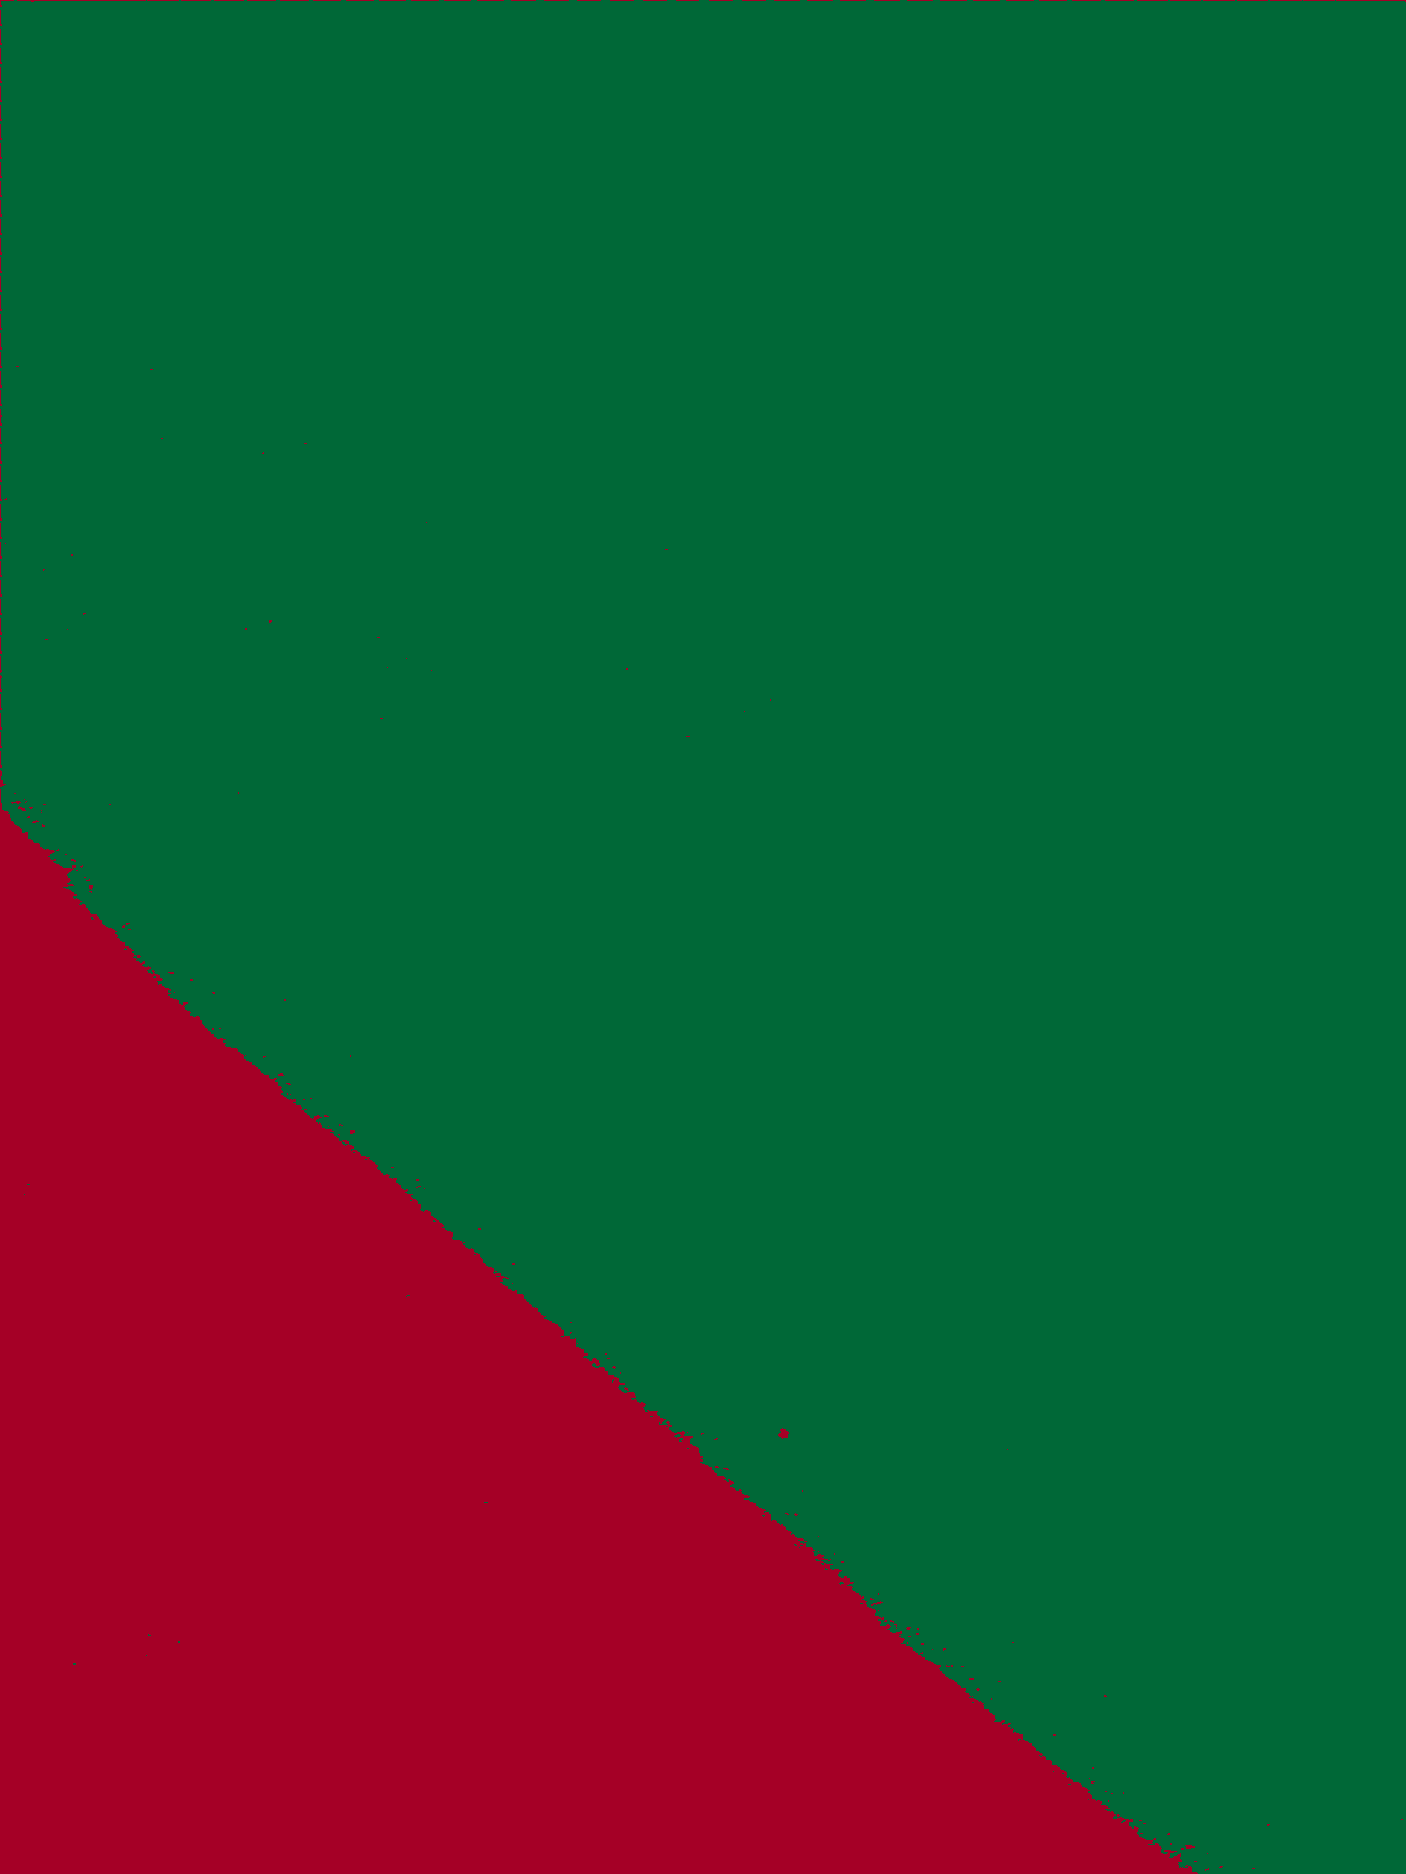
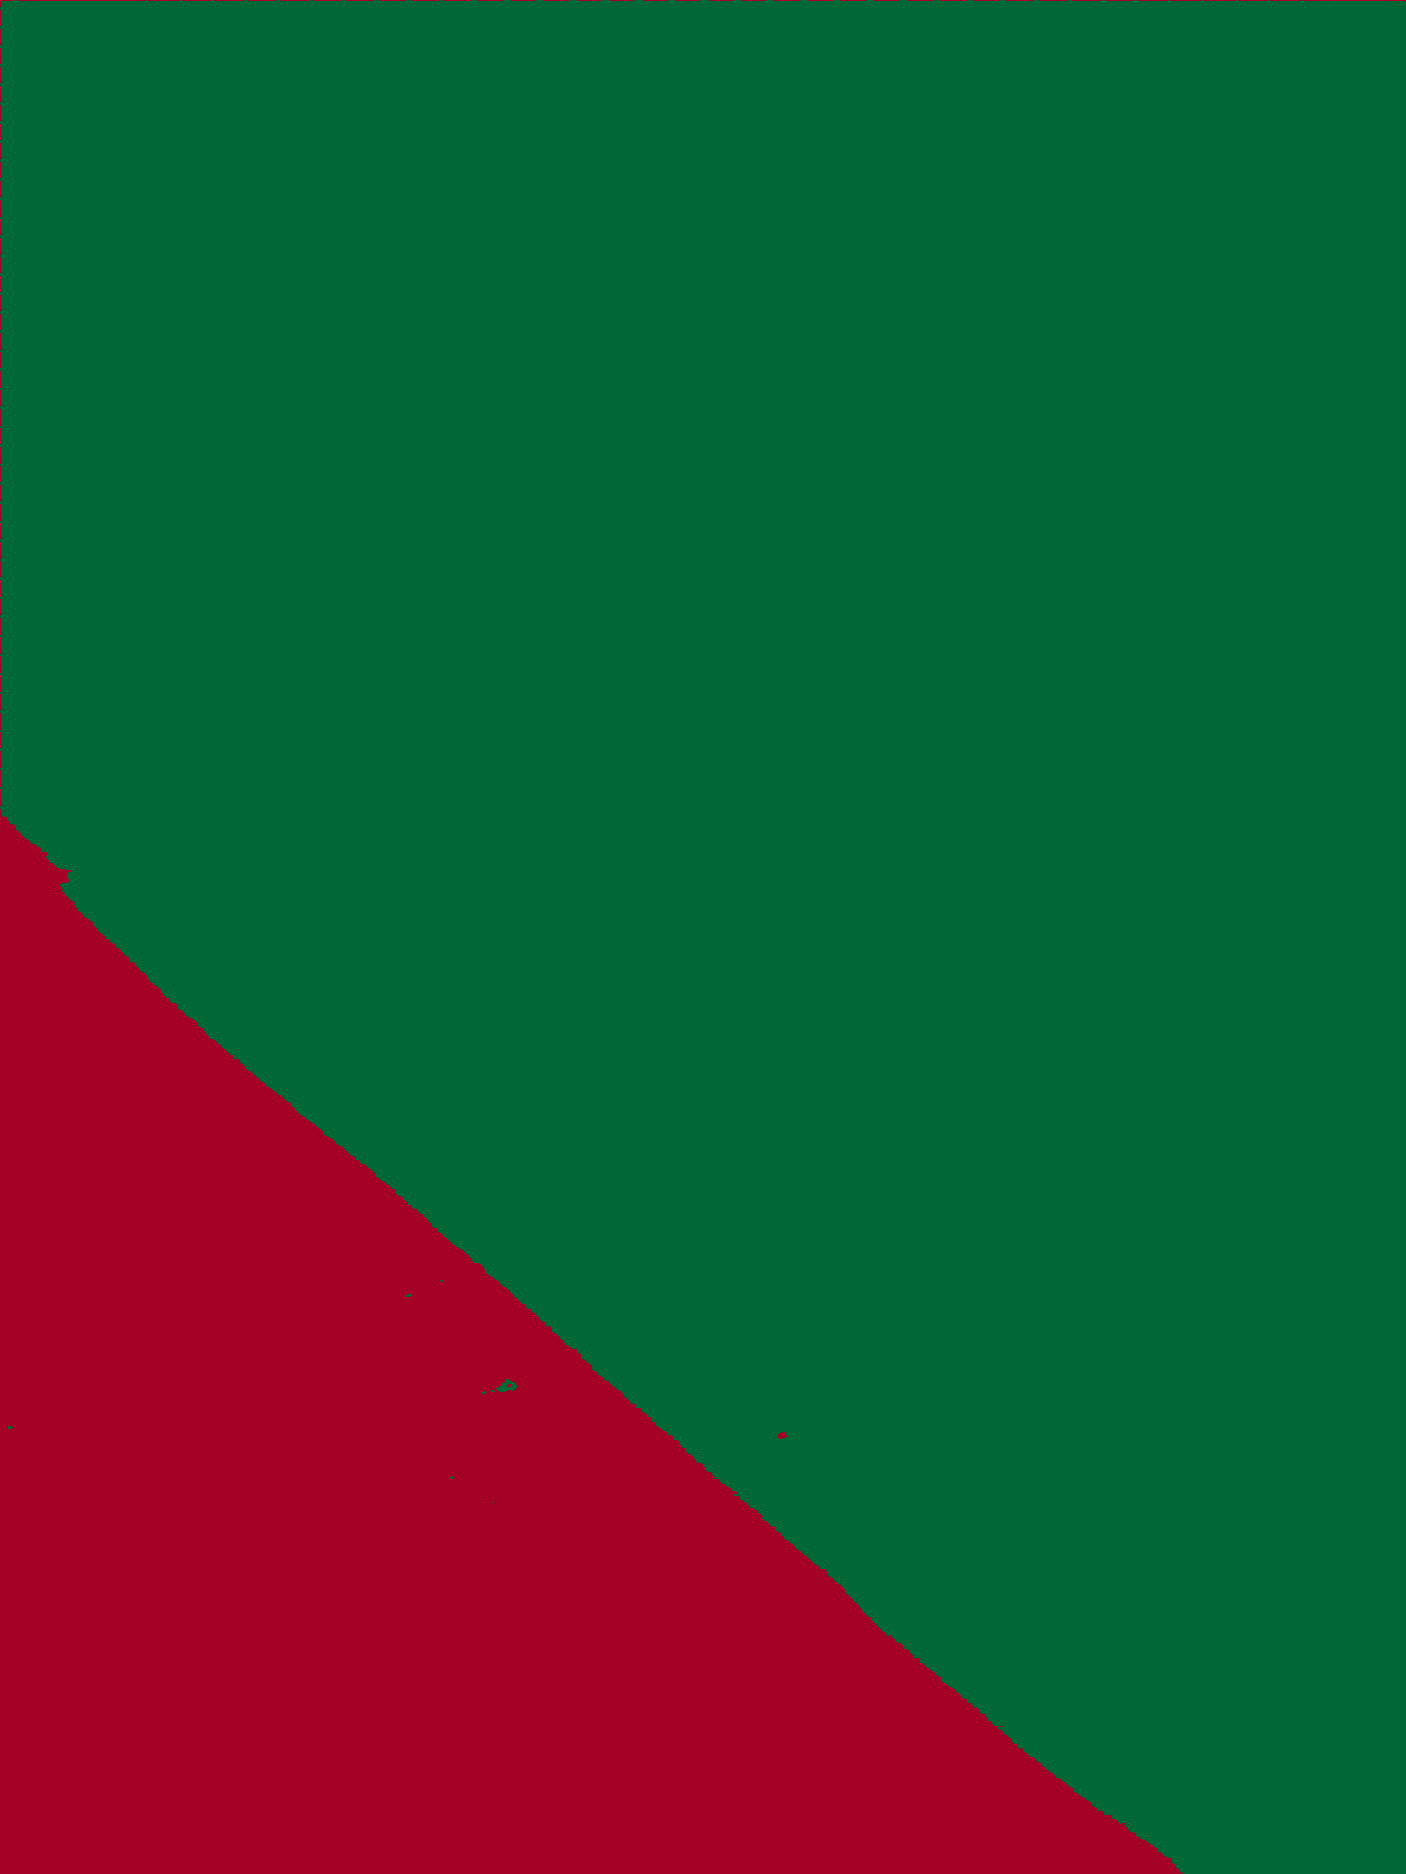
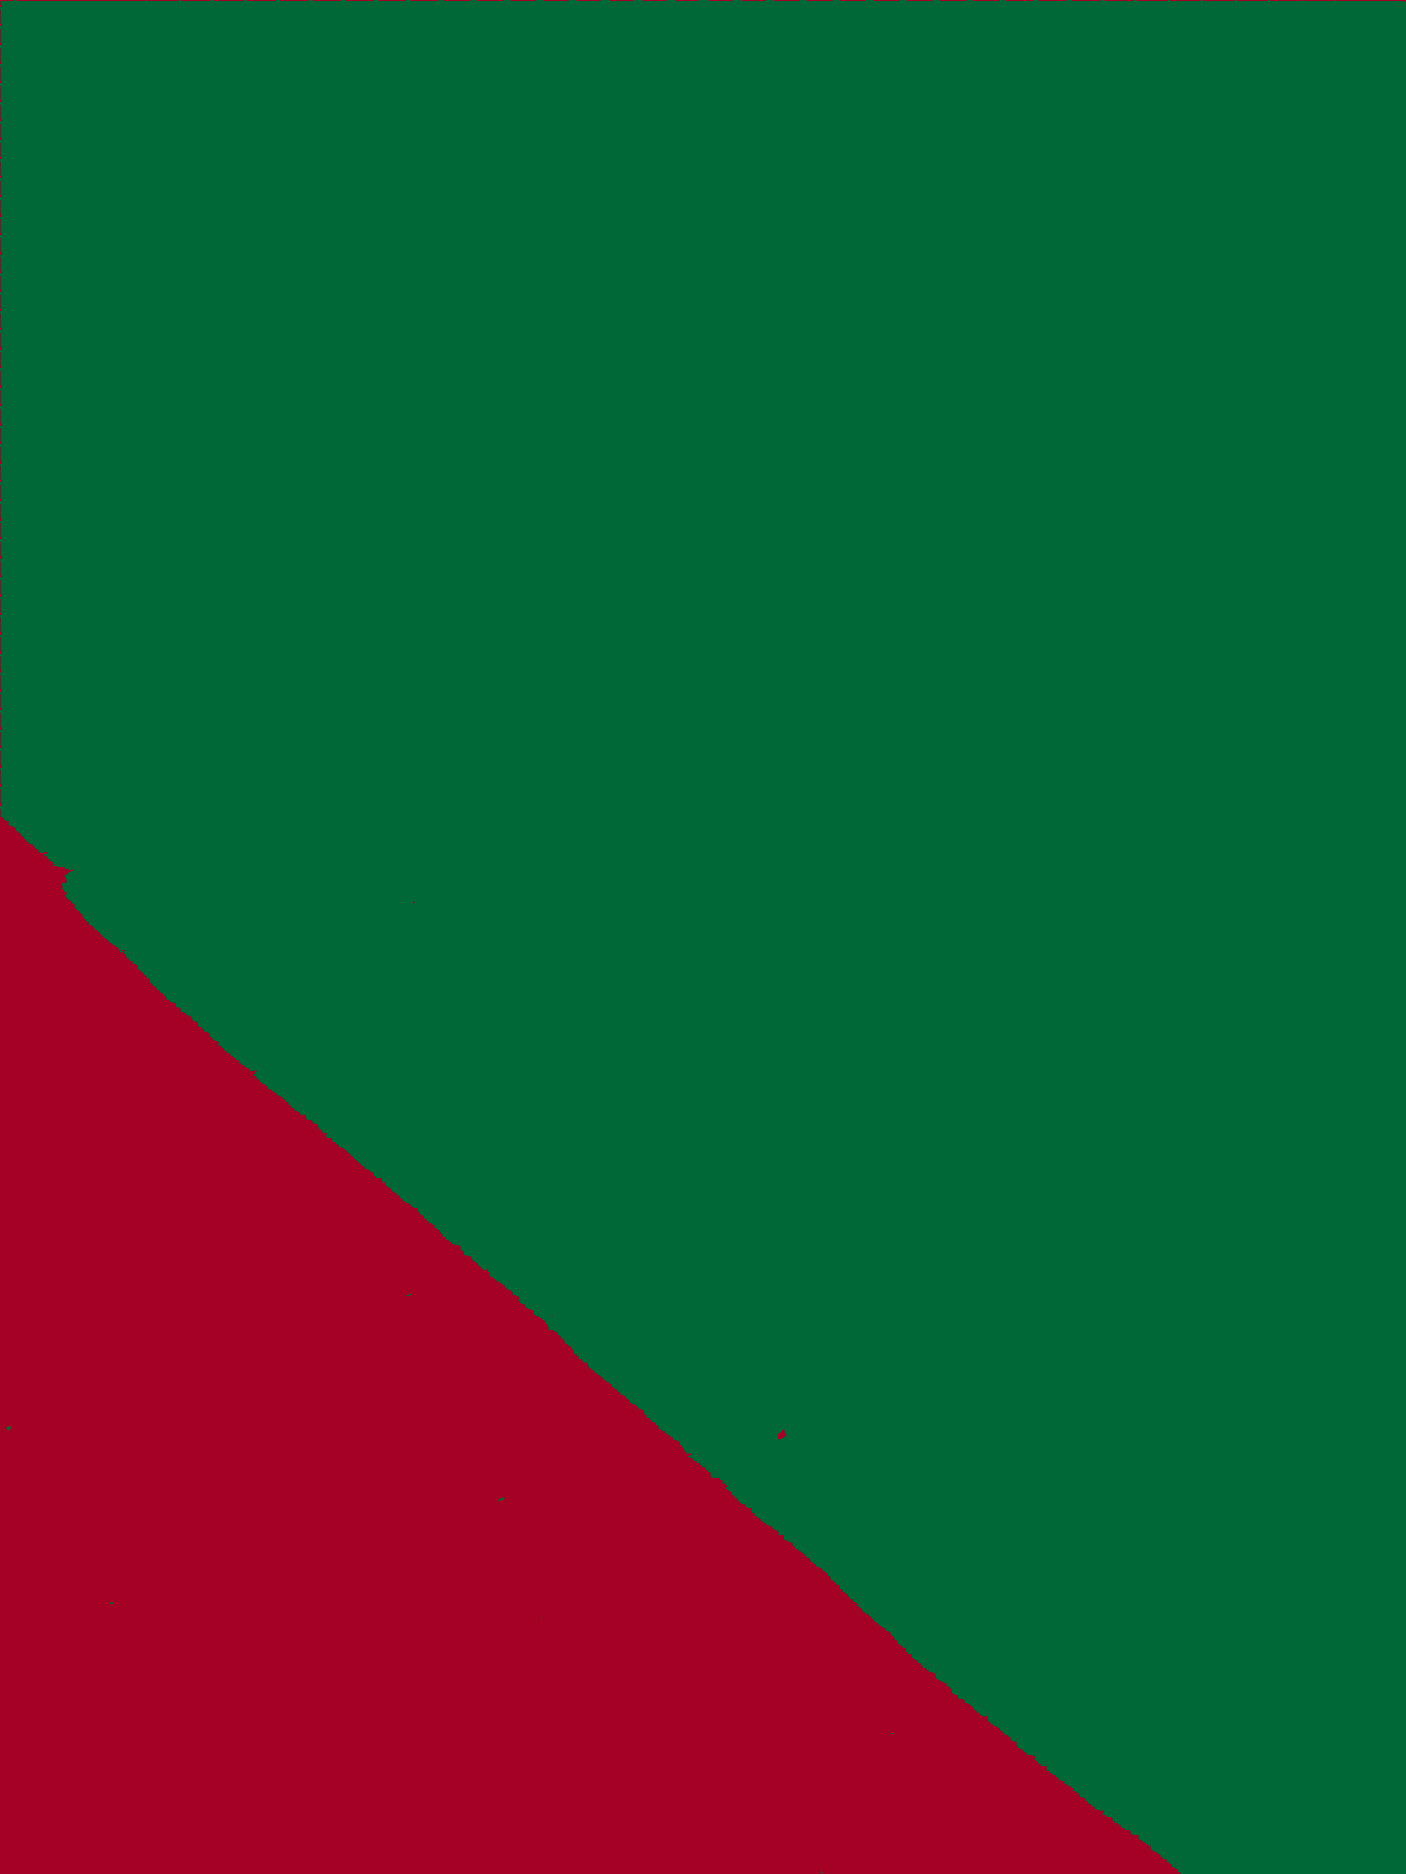

In [16]:
# Tworzenie mapy i dodanie NDVI jako warstwy rastrowej
minx, miny, maxx, maxy = bounds
m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=10)
for year in years:
    image_overlay = ImageOverlay(
        image=water_mask_colored_by_year.get(year),
        bounds=[[aoi_miny, aoi_minx], [aoi_maxy, aoi_maxx]],
        opacity=0.5,
        name=f"{year} Mask"
    )
    image_overlay.add_to(m)


for year, gdf in water_polygons_by_year.items():
    geojson = folium.GeoJson(
        data=gdf.__geo_interface__,
        name=f"{year} Poligony",
        style_function=lambda feature: {
            'fillColor': 'blue',
            'color': 'blue',
            'weight': 1,
            'fillOpacity': 0.3,
        },
        tooltip=folium.GeoJsonTooltip(fields=['year'])
    )
    geojson.add_to(m)

# Dodanie AOI jako poligon
#folium.Polygon(
#    locations=[(lat, lon) for lon, lat in aoi["coordinates"][0]],
#    color='blue',
#    weight=2,
#    fill=True,
#    fill_opacity=0.2,
#    popup='AOI'
#).add_to(m)

# Dodanie opcji sterowania warstwami
folium.LayerControl().add_to(m)

# Wyświetlenie mapy
m